In [1]:
from omegaconf import OmegaConf
import os, sys
import torch
import glob
import pickle
import pandas as pd
import numpy as np
from scipy.stats import norm as scipy_norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pytorch_lightning import Trainer
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from models import CuboidTransformerModel
from models.lightning import SEVIRPLModule

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
model_name="earthformer_drop_0.1"
exts = [""] + ["_" + str(i) for i in range(1, 10)]
model_names = [model_name + ext for ext in exts]
save_dirs = ["../models/experiments/{}/".format(mname) for mname in model_names]
oc_files = [os.path.join(save_dir, "cfg.yaml") for save_dir in save_dirs]
checkpoints = [os.path.join(save_dir, "checkpoints/") for save_dir in save_dirs]
oc_from_files = [OmegaConf.load(open(oc_file, "r")) for oc_file in oc_files]

In [4]:
dataset_oc = OmegaConf.to_object(oc_from_files[0].dataset)
micro_batch_size=1
dm = SEVIRPLModule.get_sevir_datamodule(
        dataset_oc=dataset_oc,
        micro_batch_size=micro_batch_size,
        num_workers=8,)
dm.prepare_data()
dm.setup()

In [5]:
ckpts = [glob.glob(checkpoint_dir + '*.ckpt') for checkpoint_dir in checkpoints]
for c in ckpts:
    c.sort()
curr_ckpt = [ckpt[1] for ckpt in ckpts]
print(curr_ckpt)

['../models/experiments/earthformer_drop_0.1/checkpoints/model-epoch=029.ckpt', '../models/experiments/earthformer_drop_0.1_1/checkpoints/model-epoch=022.ckpt', '../models/experiments/earthformer_drop_0.1_2/checkpoints/model-epoch=032.ckpt', '../models/experiments/earthformer_drop_0.1_3/checkpoints/model-epoch=030.ckpt', '../models/experiments/earthformer_drop_0.1_4/checkpoints/model-epoch=033.ckpt', '../models/experiments/earthformer_drop_0.1_5/checkpoints/model-epoch=028.ckpt', '../models/experiments/earthformer_drop_0.1_6/checkpoints/model-epoch=031.ckpt', '../models/experiments/earthformer_drop_0.1_7/checkpoints/model-epoch=022.ckpt', '../models/experiments/earthformer_drop_0.1_8/checkpoints/model-epoch=036.ckpt', '../models/experiments/earthformer_drop_0.1_9/checkpoints/model-epoch=044.ckpt']


In [6]:
models = []
for i in range(len(oc_from_files)):
    total_num_steps = SEVIRPLModule.get_total_num_steps(
        epoch=oc_from_files[i].optim.max_epochs,
        num_samples=dm.num_train_samples,
        total_batch_size=oc_from_files[i].optim.total_batch_size,
    )

    pl_module = SEVIRPLModule.load_from_checkpoint(curr_ckpt[i], total_num_steps=total_num_steps, save_dir=model_names[i], oc_file=oc_files[i])
    pl_module.eval()
    models.append(pl_module.torch_nn_module)

/home/idies/workspace/Storage/akhot2/persistent/earthformer/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
test_loader = dm.test_dataloader()

In [9]:
pl_module.test_mae.reset()
pl_module.test_mse.reset()
pl_module.test_score.reset()

for batch_idx, batch in enumerate(test_loader):
    data_seq = batch['vil'].contiguous()
    x = data_seq[pl_module.in_slice].to(device)
    y = data_seq[pl_module.out_slice].to(device)
    micro_batch_size = x.shape[pl_module.layout.find("N")]
    data_idx = int(batch_idx * micro_batch_size)
    
    yhats = []
    for i in range(10):
        output = models[i](x)
        yhats.append(output.detach())

    yhats = torch.cat(yhats, dim=0)
    y_hat = torch.mean(yhats, dim=0)[None, ...]
    epistemic = torch.var(yhats, dim=0)
    
    step_mse = pl_module.test_mse(y_hat, y)
    step_mae = pl_module.test_mae(y_hat, y)
    pl_module.test_score.update(y_hat, y)
    
print('MSE: ', pl_module.test_mse.compute().cpu().numpy())
print('MAE: ', pl_module.test_mae.compute().cpu().numpy())
test_score = pl_module.test_score.compute()
print(test_score)

MSE:  0.0033359658
MAE:  0.024369549
{16: {'csi': 0.7665899395942688, 'pod': 0.9079710841178894, 'sucr': 0.8311710953712463, 'bias': 2.4837749004364014}, 74: {'csi': 0.6947451233863831, 'pod': 0.795941174030304, 'sucr': 0.8453066945075989, 'bias': 1.8453655242919922}, 133: {'csi': 0.42250069975852966, 'pod': 0.5210493803024292, 'sucr': 0.6907718181610107, 'bias': 1.1842341423034668}, 160: {'csi': 0.30811214447021484, 'pod': 0.3569198548793793, 'sucr': 0.6926061511039734, 'bias': 0.5527361631393433}, 181: {'csi': 0.2613465487957001, 'pod': 0.2978154718875885, 'sucr': 0.6809422969818115, 'bias': 0.3981282711029053}, 219: {'csi': 0.1436092108488083, 'pod': 0.15833820402622223, 'sucr': 0.6068893671035767, 'bias': 0.14167769253253937}, 'avg': {'csi': 0.4328172778089841, 'pod': 0.5063391948739687, 'sucr': 0.7246145705382029, 'bias': 1.1009861156344414}}


In [10]:
import sys
sys.path.append('../') # add sevir module to path
from utils.visualization.sevir_cmap import get_cmap, VIL_COLORS, VIL_LEVELS
from matplotlib.patches import Patch

# Get colormaps for encoded types
cmap_dict = lambda s: {'cmap': get_cmap(s, encoded=True)[0],
                           'norm': get_cmap(s, encoded=True)[1],
                           'vmin': get_cmap(s, encoded=True)[2],
                           'vmax': get_cmap(s, encoded=True)[3]}

In [31]:
def generate_image(target, output, mse, unc, save_path):
    frames = []
    fig,axs = plt.subplots(3,4,figsize=(22,15))
        
    for i in range(3):
        for j in range(4):
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])

    for idx, i in enumerate([10, 30, 60]):
        frame_idx = int(i / 5 - 2)
        
        f0 = axs[idx, 0].imshow(target[0, frame_idx, :, :, 0],**cmap_dict('vil'))
        axs[idx, 0].set_title('Target', fontsize=24)
        f1 = axs[idx, 1].imshow(output[0, frame_idx, :, :, 0],**cmap_dict('vil'))
        axs[idx, 1].set_title('Output', fontsize=24)
        f2 = axs[idx, 2].imshow(mse[0, frame_idx, :, :, 0])
        axs[idx, 2].set_title('RMSE', fontsize=24)
        
        # cbar = fig.colorbar(f2, ax=axs[idx, 2], orientation='vertical')
        
        f3 = axs[idx, 3].imshow(unc[0, frame_idx, :, :, 0])
        axs[idx, 3].set_title('Uncertainty', fontsize=24)
        
        # cbar = fig.colorbar(f3, ax=axs[idx, 3], orientation='vertical')
        
    
    # Legend of thresholds
    num_thresh_legend = len(VIL_LEVELS) - 1
    legend_elements = [Patch(facecolor=VIL_COLORS[i],
                             label=f'{int(VIL_LEVELS[i - 1])}-{int(VIL_LEVELS[i])}')
                       for i in range(1, num_thresh_legend + 1)]
    x_legend = -0.8
    axs[0][0].legend(handles=legend_elements, loc='center left',
                    bbox_to_anchor=(x_legend, -0.),
                    borderaxespad=0, frameon=False, fontsize='20')

    plt.savefig(save_path)
    plt.show()

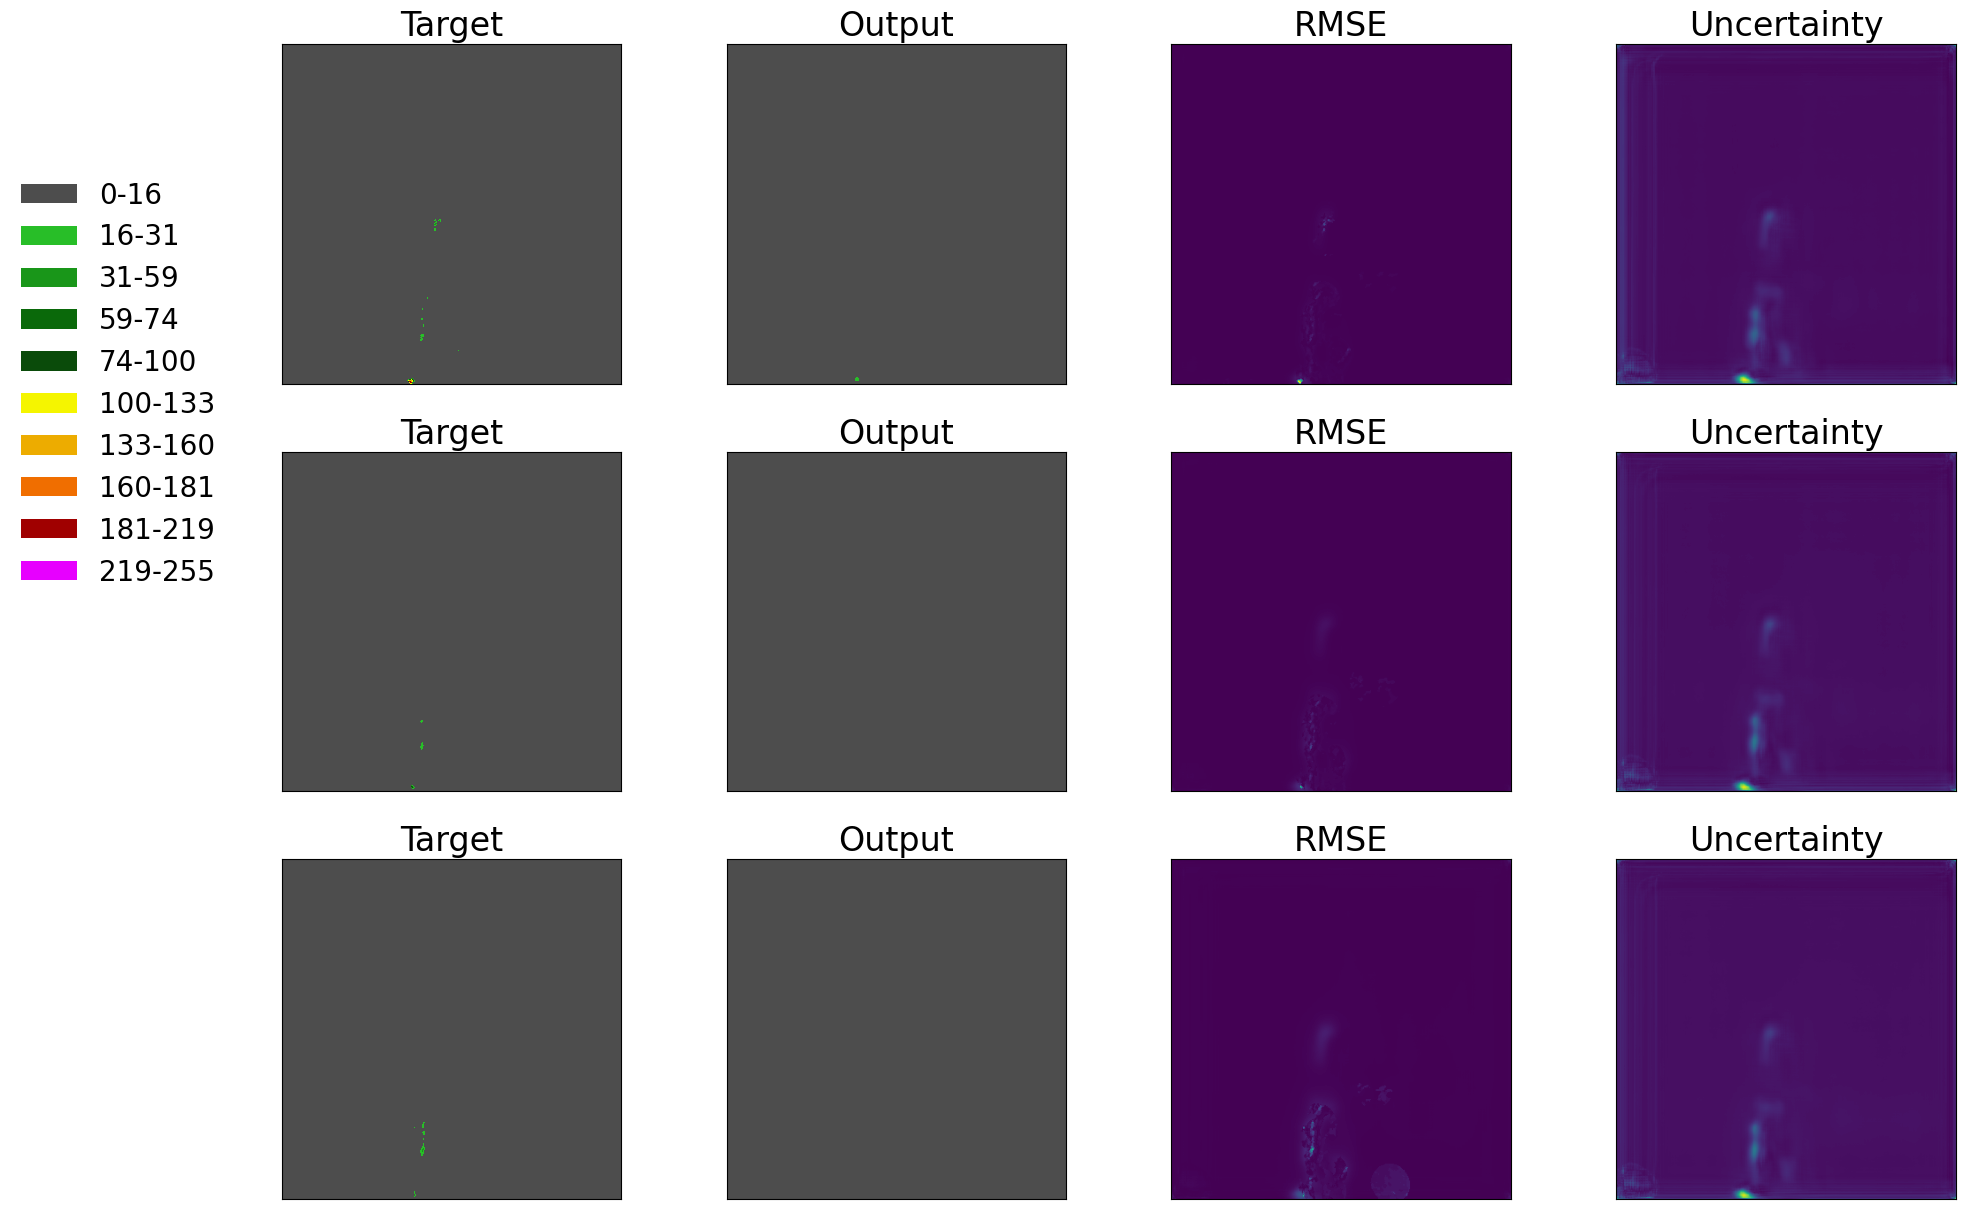

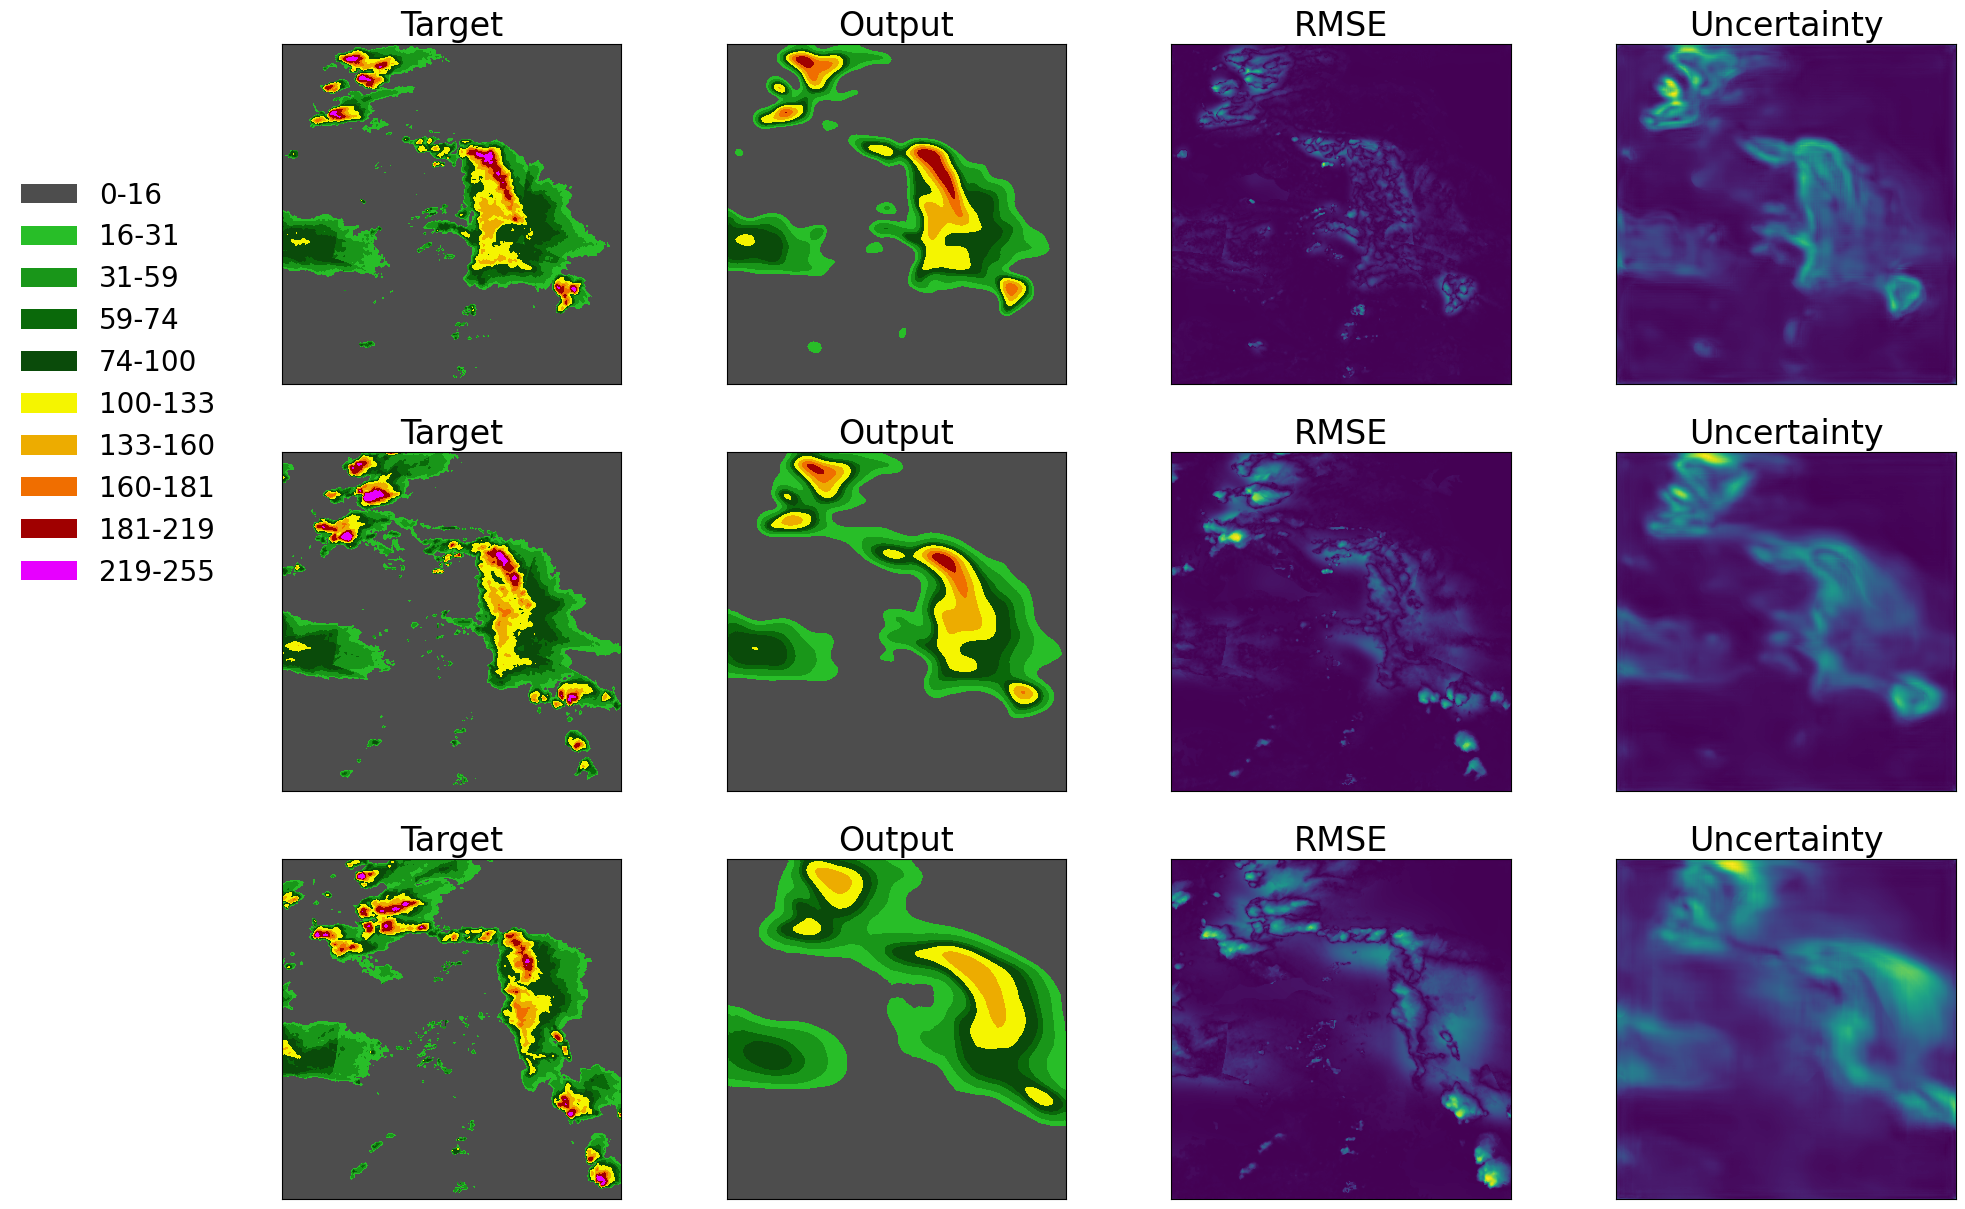

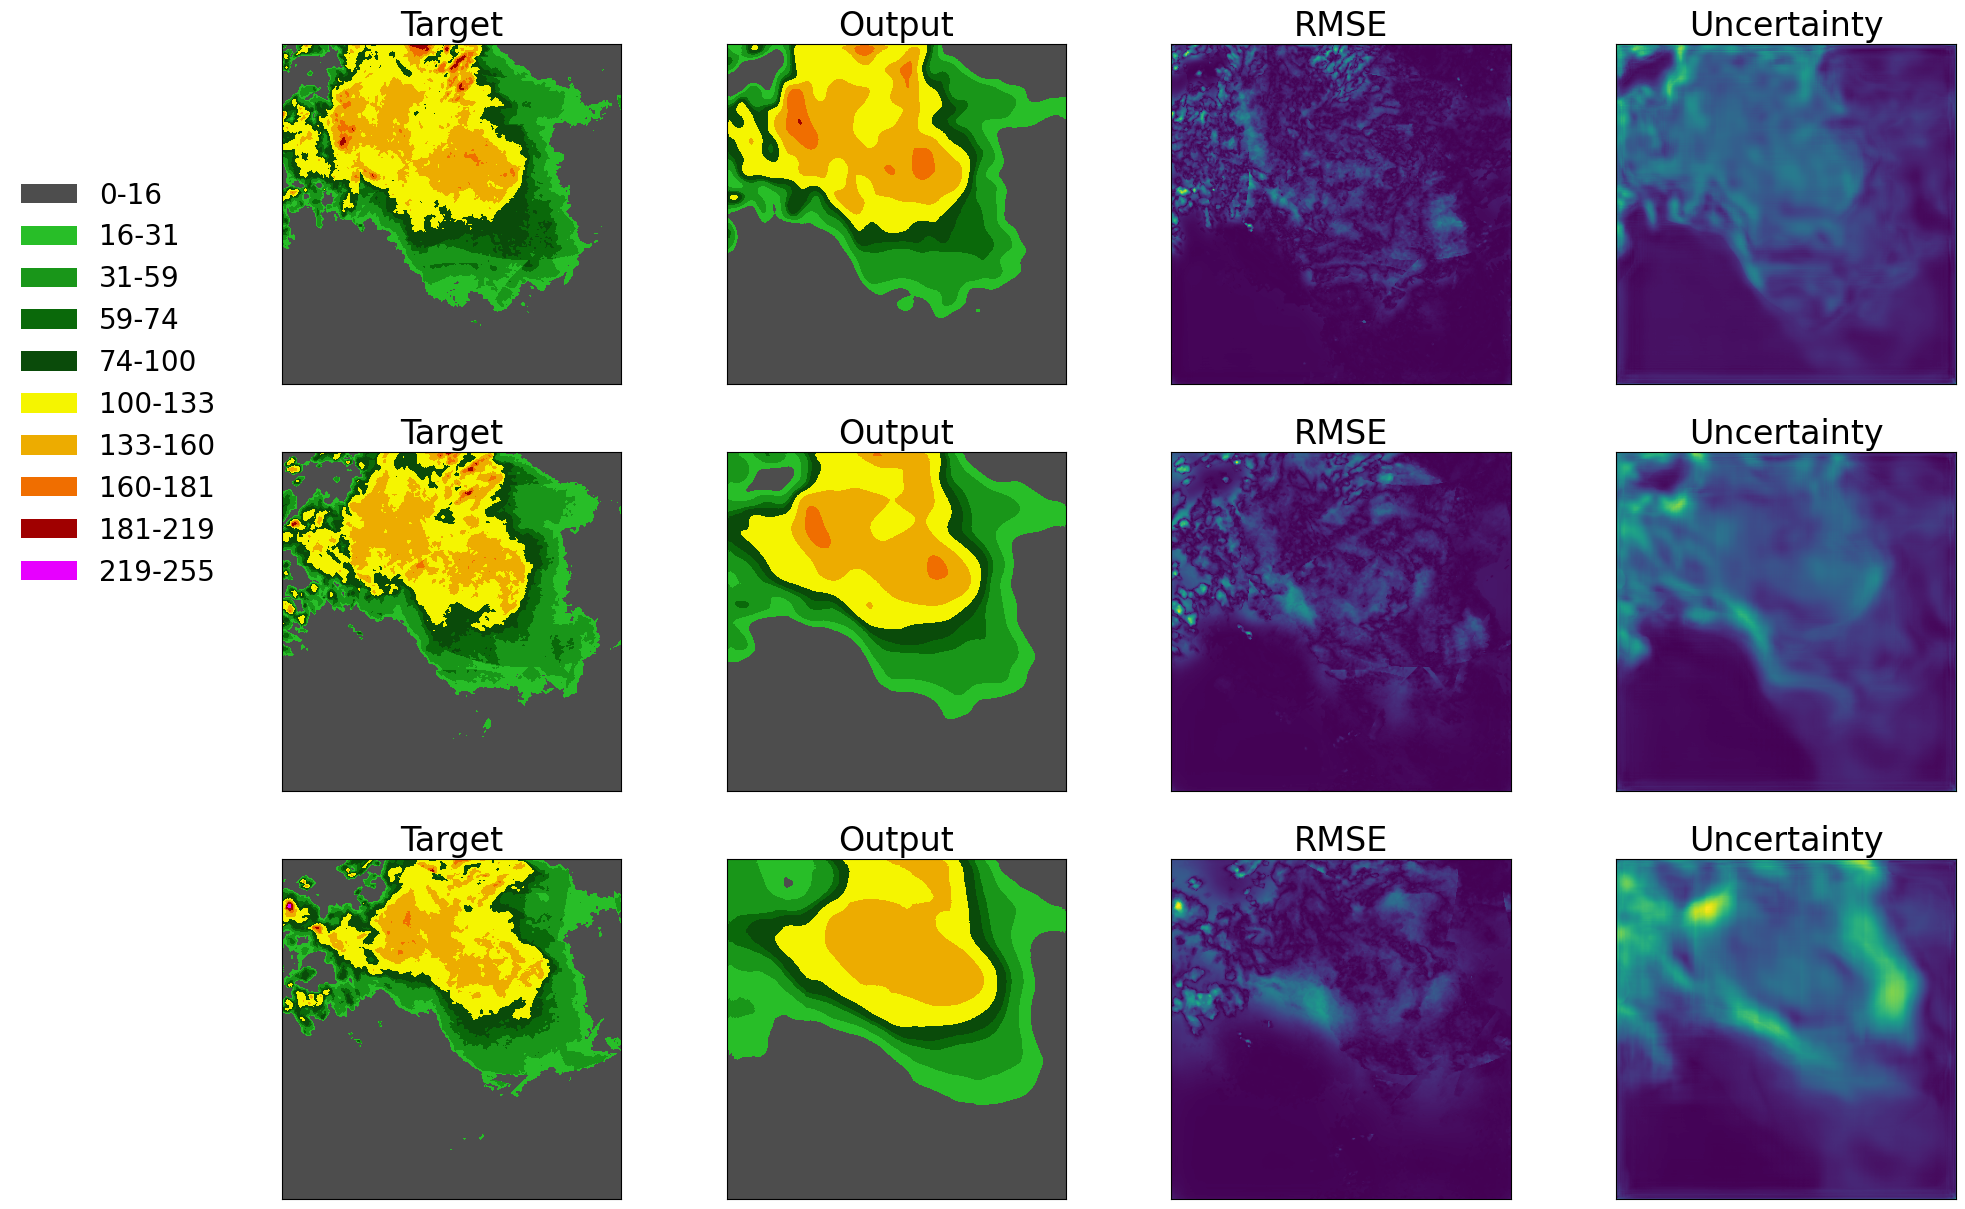

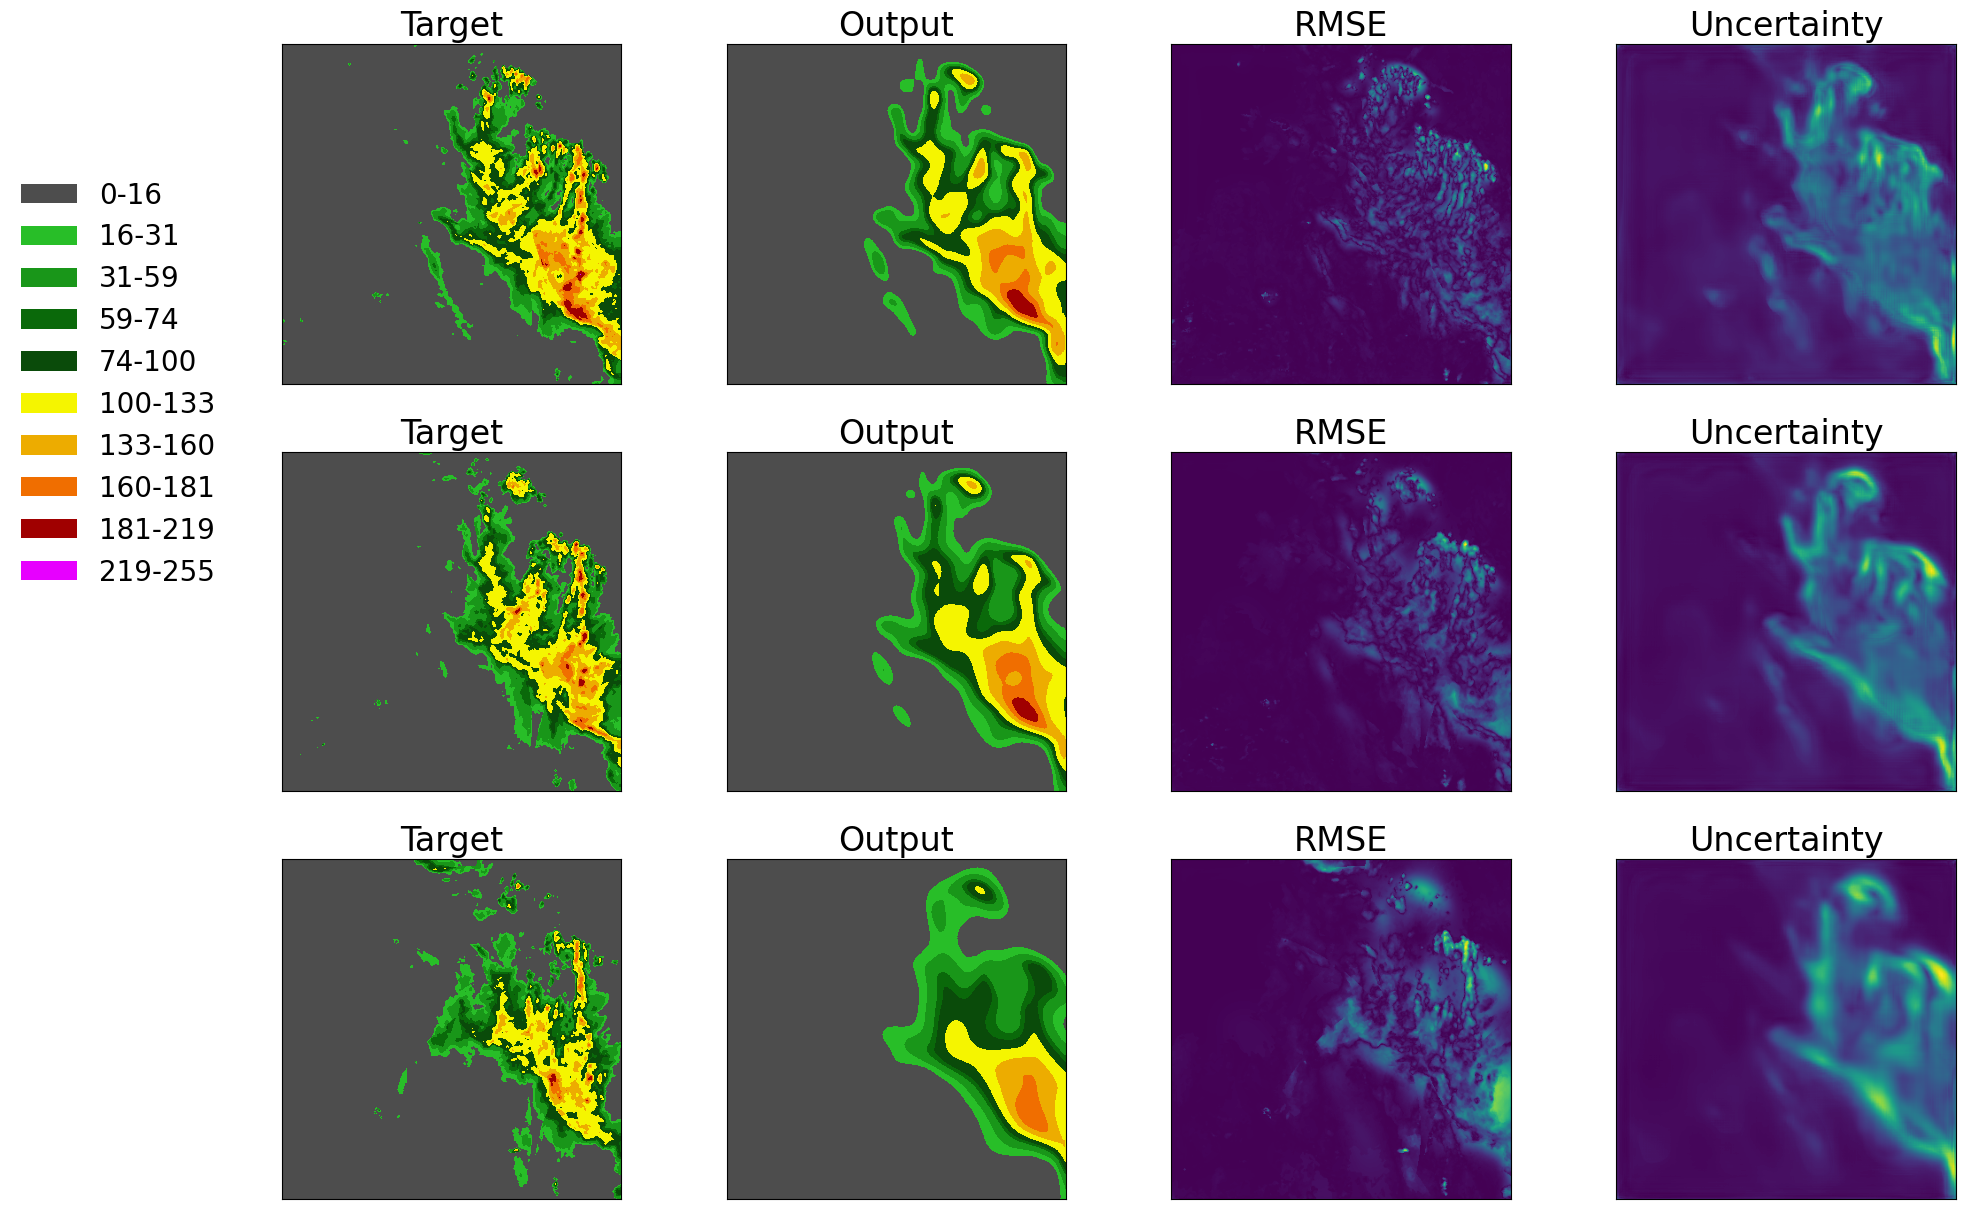

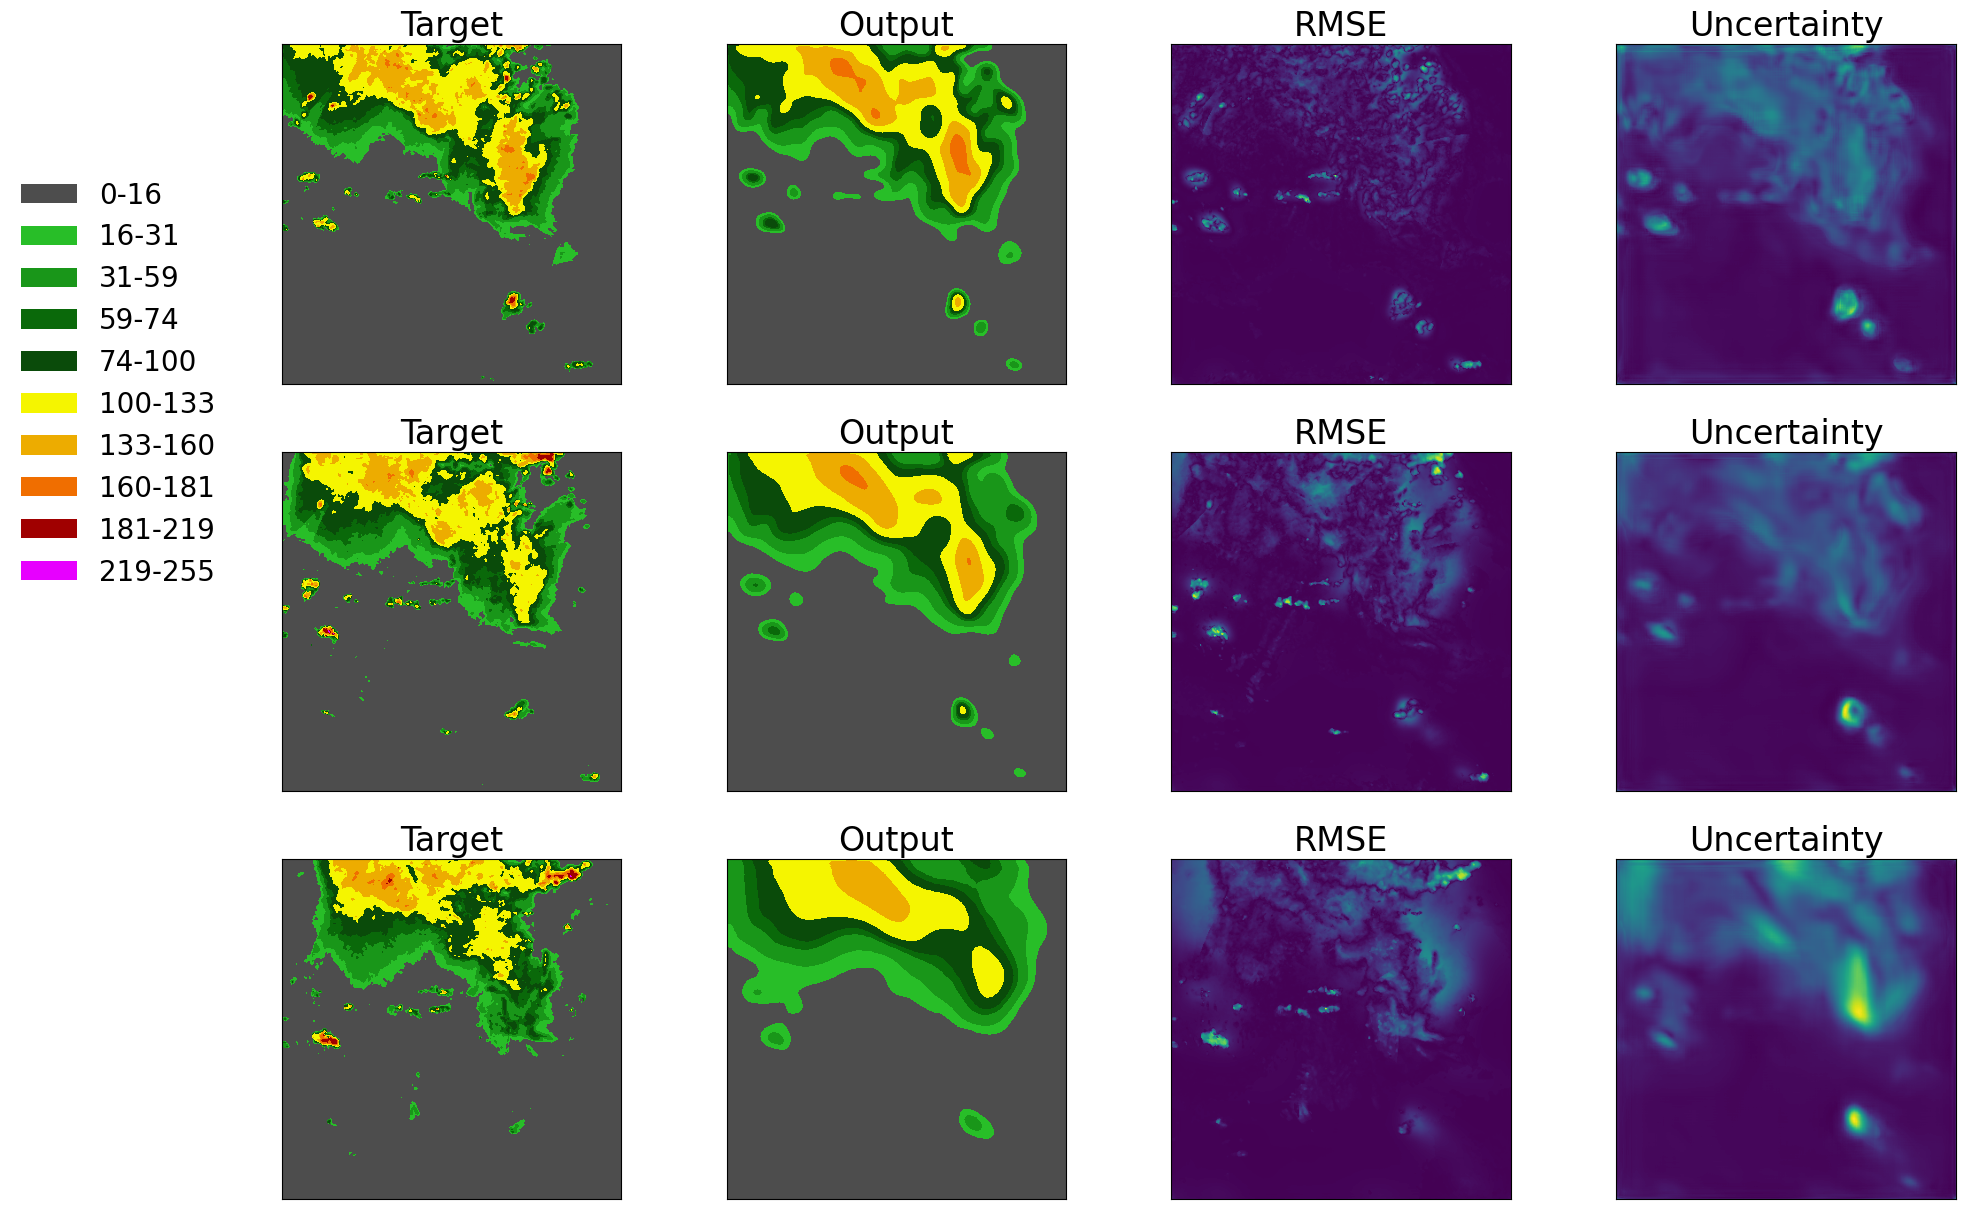

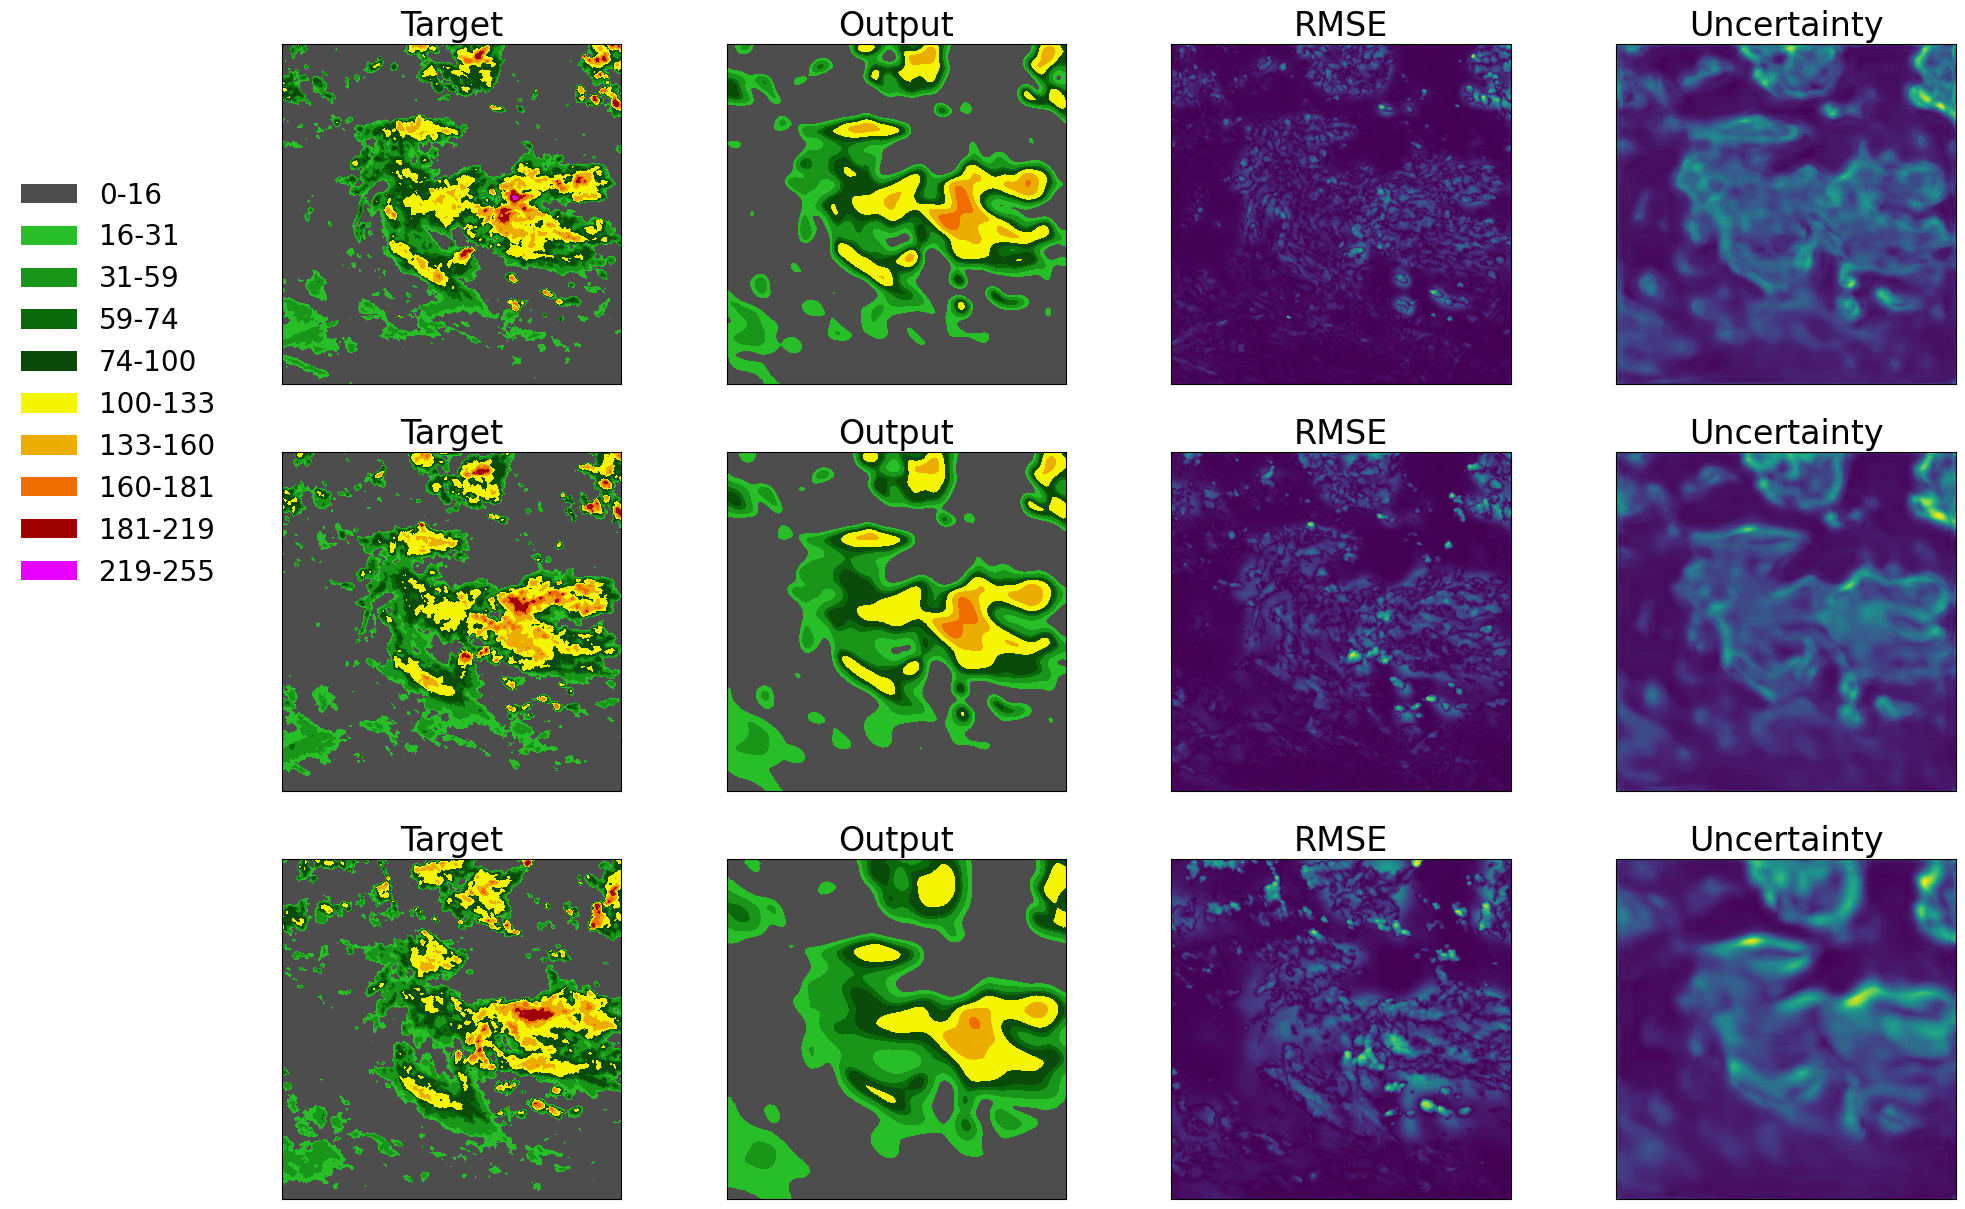

In [32]:
for batch_idx, batch in enumerate(test_loader):
    if batch_idx not in pl_module.test_example_data_idx_list:
        if batch_idx > pl_module.test_example_data_idx_list[-1]:
            break
        continue
    data_seq = batch['vil'].contiguous()
    x = data_seq[pl_module.in_slice].to(device)
    y = data_seq[pl_module.out_slice].to(device)
    micro_batch_size = x.shape[pl_module.layout.find("N")]
    data_idx = int(batch_idx * micro_batch_size)
    
    yhats = []
    for i in range(10):
        output = models[i](x)
        yhats.append(output.detach())

    yhats = torch.cat(yhats, dim=0)
    y_hat = torch.mean(yhats, dim=0)[None, ...]
    epistemic = torch.var(yhats, dim=0)[None, ...]
    
    generate_image(y.detach().float().cpu().numpy()* 255,
                   y_hat.detach().float().cpu().numpy()* 255,
                   ((y - y_hat)**2).detach().float().cpu().sqrt().numpy(),
                   epistemic.detach().float().cpu().sqrt().numpy(),
                   "figures/Ensemble_" + model_name + "_" + str(batch_idx) + ".pdf")

In [31]:
epistemic.shape

torch.Size([12, 384, 384, 1])